# 데이터 전처리

@author 컴퓨터과학과 황승현
KoGes 데이터 전처리

2023-05-29 수정... 데이터 쳐내기

전처리 절차

1. 데이터셋 분리
    - ~~남성~~ 사용 안 함
    - 여성(폐경 전) < AS1_PMYN_C: 1
    - 여성(폐경 후) < AS1_PMYN_C: 2
2. 각각 사용할 독립변수, 종속변수 행 추출
3. 질환유무, 약물력 변수 가공
4. 가족력, 가족과의 관계 변수 가공
    - 부, 모, 형제자매, 기타 -> 부모, 형제자매, 기타, 해당없음
5. 종속변수 AS1_OP 가공
    - AS1_DT
    - AS1_MT
6. 데이터셋을 DataFrame으로 불러오고 독립변수는 4가지로 분류 (binary, cath0, cath1, cnt, tumor_name)
  - binary: 범주형(binary) 변수, 0 / 1 로 변경
  -  catH0: 계층 없는 범주형(>03) 변수, 벡터화(one-hot-encoding)
  -  catH1: 계층 있는 범주형 변수, 표준화
  -    cnt: 연속형 변수, 정규화, 표준화
  - tumor_name
7. 결측값 제거 : 일단 0으로 대치
8. 연속형 변수 스케일링
  - 정규화(normalization): 0, 1
  - 표준화(standardization): 평균: 0 표준편차: 1
  - 계층화(quantile transform): 4분위 수
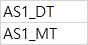

## 준비

- 라이브러리 불러오기
- 데이터셋, 사용할 변수 불러오기

In [2]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

In [3]:
# 데이터셋 불러오기
# dataset = pd.read_csv("dataset/Dataset_OP_230316_raw.csv", index_col=0, na_values=[77777, 99999, '#NULL!', ' ']) # 사용안함
# dataset = pd.read_csv("dataset/Dataset_OP_230330_raw.csv", index_col=0, na_values=[77777, 99999, '#NULL!', ' ']) # 사용안함
# dataset = pd.read_csv("dataset/Dataset_OP_230417_raw.csv", index_col=0, na_values=[77777, 99999, '#NULL!', ' ']) # 사용안함
# dataset = pd.read_csv("dataset/Dataset_OP_230424_raw.csv", index_col=0, na_values=[77777, 99999, '#NULL!', ' ']) # 사용안함
dataset = pd.read_csv("dataset/Dataset_OP_230428_raw.csv", index_col=0, na_values=[77777, 99999, '#NULL!', ' '])
dataset

C:\Users\sh22h\AppData\Local\Temp\ipykernel_24060\3045930773.py:6: DtypeWarning: Columns (7,9,156,299) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv("dataset/Dataset_OP_230428_raw.csv", index_col=0, na_values=[77777, 99999, '#NULL!', ' '])


,AS1_SEX,AS1_AGE,AS1_FAMNUM,AS1_HAND,AS1_SEAS,AS1_MARRYA,AS1_MARRYAETC,AS1_RELIG,AS1_RELIGETC,AS1_RELIGPRT,...,AS1_PUFA,AS1_N3PUFA,AS1_N6PUFA,AS1_PRAL,AS1_NEAP,AS1_DII,AS1_KHEI,AS1_DASH,AS1_aMED,AS1_HOMAIR
DIST_ID,,,,,,,,,,,,,,,,,,,,,
NIH2307795046,1,53,4.0,1.0,3.0,2.0,NaN,3.0,NaN,1.0,...,3.193209,0.244105,0.919774,-2.628106,22.154756,2.069437,24,22,4,2.718878
NIH2307713334,2,44,2.0,1.0,2.0,2.0,NaN,4.0,NaN,NaN,...,5.760385,0.372534,3.071067,18.912062,37.523511,2.371169,45,27,4,0.306401
NIH2307455306,2,43,6.0,1.0,2.0,2.0,NaN,3.0,NaN,1.0,...,4.104470,0.289509,2.988182,-4.043056,25.554372,1.500256,37,24,5,1.272971
NIH2307778268,1,61,4.0,1.0,4.0,2.0,NaN,3.0,NaN,1.0,...,6.447458,0.428001,3.900943,18.623976,41.971904,2.394346,47,23,2,0.379918
NIH2307137554,2,64,4.0,1.0,1.0,2.0,NaN,3.0,NaN,1.0,...,24.797659,2.695854,15.169099,0.648516,25.068314,2.054646,56,29,5,1.618351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NIH2307591031,2,60,3.0,1.0,3.0,2.0,NaN,1.0,NaN,2.0,...,5.642395,0.158707,2.560059,6.793156,35.047024,2.624506,43,25,5,1.975572
NIH2307808901,2,62,4.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,...,9.044120,0.820519,3.861349,17.183396,40.640374,1.596741,77,25,4,1.416057
NIH2307930134,2,65,2.0,1.0,3.0,3.0,NaN,1.0,NaN,3.0,...,7.730632,0.431979,4.279104,25.785485,43.224860,2.807543,46,25,3,4.158371


KeyError: 'AS1_OP'

In [5]:
# 특성별로 분류
# var_to_use = pd.read_csv("dataset/var_to_use_2023-03-30T2240I.csv")
# var_to_use = pd.read_csv("dataset/var_to_use_2023-04-21T1258I.csv")
# var_to_use = pd.read_csv("dataset/var_to_use_2023-04-24T1830I.csv")
var_to_use = pd.read_csv("dataset/var_to_use_2023-04-28T1610I.csv")
var_to_use


,binary,cath0,cath1,cnt,dependent
0,AS1_AL,AS1_BRCA,AS1_DRINK,AS1_AGE,AS1_DT
1,AS1_ARRM,AS1_DRCP,AS1_EDUA,AS1_ALBUMIN_TR,AS1_MT
2,AS1_AS,AS1_DRFH,AS1_INCOME,AS1_ALT_TR,NaN
3,AS1_CD,AS1_FMCDREL_N,AS1_PHYACTH,AS1_aMED,NaN
4,AS1_CH,AS1_FMCDREL_O,AS1_PHYACTL,AS1_AST_TR,NaN
...,...,...,...,...,...
56,NaN,NaN,NaN,AS1_VITE,NaN
57,NaN,NaN,NaN,AS1_VITK,NaN
58,NaN,NaN,NaN,AS1_WAIST,NaN
59,NaN,NaN,NaN,AS1_WEIGHT,NaN


## 데이터 가공

- 기존 데이터로 새로운 데이터 만들기
- if 문 쓰면 안됨!
    - The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
- np.where 사용할 것!

### 종속변수 결측값 drop

In [6]:
# 종속변수의 결측값이 있으면 drop
dataset.dropna(subset=['AS1_DT', 'AS1_MT'], inplace=True)

# 남성(1) drop, 여성(2)만 가져옴
dataset = dataset[dataset['AS1_SEX'] == 2]

# 새로운 종속변수 만들기 OP: 골다공증 여부
dataset['OP'] = np.where((dataset['AS1_DT'] <= -2.5) | (dataset['AS1_MT'] <= -2.5), 1, 0)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4680 entries, NIH2307713334 to NIH2307534318
Columns: 822 entries, AS1_SEX to OP
dtypes: float64(780), int32(1), int64(36), object(5)
memory usage: 29.4+ MB


C:\Users\sh22h\AppData\Local\Temp\ipykernel_24060\1920078704.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['OP'] = np.where((dataset['AS1_DT'] <= -2.5) | (dataset['AS1_MT'] <= -2.5), 1, 0)


In [21]:
dataset['AS1_PHYSTB'].value_counts()

AS1_PHYSTB
0.0    1432
1.0     821
2.0     782
3.0     470
5.0     349
4.0     347
6.0     204
8.0     148
7.0      77
Name: count, dtype: int64

In [23]:
test = dataset[dataset['OP'] == 1]

test['AS1_PHYSTB'].value_counts()

AS1_PHYSTB
0.0    279
1.0    179
2.0    133
3.0     80
4.0     65
5.0     57
6.0     47
8.0     23
7.0     21
Name: count, dtype: int64

In [24]:
test2 = dataset[dataset['OP'] == 0]

test2['AS1_PHYSTB'].value_counts()

AS1_PHYSTB
0.0    1153
2.0     649
1.0     642
3.0     390
5.0     292
4.0     282
6.0     157
8.0     125
7.0      56
Name: count, dtype: int64

### 각종 질환 가공

- 질환 유무
    - 각종 종양 유무 (AS1_TOTCA1)
- 약물력
- 가족력

In [49]:
# 질환유무 가공
disease_list = np.array(['HT', 'DM', 'UL', 'AL', 'MI', # 질환 목록
                         'TH', 'CH', 'CD', 'LP', 'AS',
                         'CL', 'PV', 'KD', 'CV', 'HN',
                         'GT', 'TOTCA1'])

dataset['AS1_ARRM'] = np.where((dataset['AS1_JOAR'] == 2) | (dataset['AS1_JORM'] == 2) | (dataset['AS1_TRTAR'] == 2), 1, 0) # 관절혐은 조건 3가지 만족하면 1 아니면 0

for x in disease_list:
    dataset['AS1_'+x] = np.where((dataset['AS1_PD'+x] == 2) | (dataset['AS1_TRT'+x] == 2), 1, 0) # 질환여부 정의. AS1_PDㅇㅇ 또는 AS1_TRTㅇㅇ 이 2이면 1 아니면 0


C:\Users\sh22h\AppData\Local\Temp\ipykernel_40992\2030893350.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['AS1_ARRM'] = np.where((dataset['AS1_JOAR'] == 2) | (dataset['AS1_JORM'] == 2) | (dataset['AS1_TRTAR'] == 2), 1, 0) # 관절혐은 조건 3가지 만족하면 1 아니면 0
C:\Users\sh22h\AppData\Local\Temp\ipykernel_40992\2030893350.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['AS1_'+x] = np.where((dataset['AS1_PD'+x] == 2) | (dataset['AS1_TRT'+x] == 2), 1, 0) # 질환여부 정의.
C:\Users\sh22h\AppData\Local\T

In [50]:
# 약물력 가공
drug_list = np.array(['ST', 'CP', 'INS', 'HT', 'AR', 
                      'UL', 'TH', 'FH', 'OS', 'DM',
                      'STK', 'AS', 'LP'])  # CP, HP 제외
for x in drug_list:
    dataset['AS1_DR'+x] = np.where((dataset['AS1_DRUG'+x] == 2) | (dataset['AS1_DRUG'+x+'CU'] == 2), 1, 0)


C:\Users\sh22h\AppData\Local\Temp\ipykernel_40992\1122588383.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['AS1_DR'+x] = np.where((dataset['AS1_DRUG'+x] == 2) | (dataset['AS1_DRUG'+x+'CU'] == 2), 1, 0)
C:\Users\sh22h\AppData\Local\Temp\ipykernel_40992\1122588383.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['AS1_DR'+x] = np.where((dataset['AS1_DRUG'+x] == 2) | (dataset['AS1_DRUG'+x+'CU'] == 2), 1, 0)
C:\Users\sh22h\AppData\Local\Temp\ipykernel_40992\1122588383.py:6: SettingWithCo

In [51]:
# 와 ChatGPT가 아니었다면 np.all과 np.any를 몰랐을거야!
# 가족력 가공
# N: 가족력 없음, P: parent 부모, S: sibling 형제자매, O: other 기타
# N: REL1A~4A까지 99999
# P: REL1A~4A중 1, 2 있을 때
# S: REL1A~4A중 3 있을 때
# O: REL1A~4A중 4 있을 때

disease_dict = {
    'HT': 4, 'DM': 4, 'CVA': 3, 'HE': 2, 'OS': 2,
    'CVB': 2, 'CD': 2, 'PV': 2, 'LP': 2, 'GT': 2,'CH': 1
}

for disease, num_family in disease_dict.items():
    dataset[f'AS1_FM{disease}REL_N'] = np.all(dataset[[f'AS1_FM{disease}REL{i}A' for i in range(1, num_family+1)]] == 99999, axis=1).astype(int)
    dataset[f'AS1_FM{disease}REL_P'] = np.any(dataset[[f'AS1_FM{disease}REL{i}A' for i in range(1, num_family+1)]] <= 2, axis=1).astype(int)
    dataset[f'AS1_FM{disease}REL_S'] = np.any(dataset[[f'AS1_FM{disease}REL{i}A' for i in range(1, num_family+1)]] == 3, axis=1).astype(int)
    dataset[f'AS1_FM{disease}REL_O'] = np.any(dataset[[f'AS1_FM{disease}REL{i}A' for i in range(1, num_family+1)]] == 4, axis=1).astype(int)

C:\Users\sh22h\AppData\Local\Temp\ipykernel_40992\3877498656.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f'AS1_FM{disease}REL_N'] = np.all(dataset[[f'AS1_FM{disease}REL{i}A' for i in range(1, num_family+1)]] == 99999, axis=1).astype(int)
C:\Users\sh22h\AppData\Local\Temp\ipykernel_40992\3877498656.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f'AS1_FM{disease}REL_P'] = np.any(dataset[[f'AS1_FM{disease}REL{i}A' for i in range(1, num_family+1)]] <= 2, axis=1).astype(int)
C:\Use

In [52]:
dataset[[f'AS1_FM{disease}REL_{family}' for disease in disease_dict.keys() for family in ['N', 'P', 'S', 'O']]]

,AS1_FMHTREL_N,AS1_FMHTREL_P,AS1_FMHTREL_S,AS1_FMHTREL_O,AS1_FMDMREL_N,AS1_FMDMREL_P,AS1_FMDMREL_S,AS1_FMDMREL_O,AS1_FMOSREL_N,AS1_FMOSREL_P,AS1_FMOSREL_S,AS1_FMOSREL_O,AS1_FMLPREL_N,AS1_FMLPREL_P,AS1_FMLPREL_S,AS1_FMLPREL_O,AS1_FMGTREL_N,AS1_FMGTREL_P,AS1_FMGTREL_S,AS1_FMGTREL_O
DIST_ID,,,,,,,,,,,,,,,,,,,,
NIH2307713334,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NIH2307455306,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NIH2307137554,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NIH2307649667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NIH2307899915,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NIH2307591031,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NIH2307808901,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
NIH2307930134,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 여성력 가공

- ~~질환~~
- 약물
- 기타 수술 (AS1_OBGYOP)
    - 자궁경부암수술/ 자궁암수술/ 자궁내막암/자궁경부암,나팔관제거수술/ 만 1 나머지는 0

In [53]:
# 여성력 가공
# 남성 데이터 셋을 제거하여 필요없음

# 남자일 경우: 0 여자일 경우: 그대로
# for x in ['CP', 'FH']:
#     dataset['AS1_DR'+x] = np.where(dataset['AS1_SEX'] == '1',
#                                    0,
#                                    np.where((dataset['AS1_DRUG'+x] == 2) | (dataset['AS1_DRUG'+x+'CU'] == 2), 2, 1))

for x in ['CP', 'FH']:
    dataset['AS1_DR'+x] = np.where((dataset['AS1_DRUG'+x] == 2) | (dataset['AS1_DRUG'+x+'CU'] == 2), 1, 0)

    
# women = np.array(['AS1_PREG', 'AS1_HYST', 'AS1_HYSTOVARYW', 'AS1_OVARYW',
#                   'AS1_OBGYOP', 'AS1_BRCA', 'AS1_DRCP', 'AS1_DRFH'])
#
# for x in women:
#     dataset[x] = np.where((dataset['AS1_SEX'] == 1), 0, dataset[x])

C:\Users\sh22h\AppData\Local\Temp\ipykernel_40992\3218887834.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['AS1_DR'+x] = np.where((dataset['AS1_DRUG'+x] == 2) | (dataset['AS1_DRUG'+x+'CU'] == 2), 1, 0)


### 타입 별 분리

In [54]:
# var_to_use의 각 열 가져옴

raw_binary = dataset.reindex(columns=(var_to_use['binary'].dropna()))
raw_cath0 = dataset.reindex(columns=(var_to_use['cath0'].dropna()))
raw_cath1 = dataset.reindex(columns=(var_to_use['cath1'].dropna()))
raw_cnt = dataset.reindex(columns=(var_to_use['cnt'].dropna()))
raw_label = dataset.reindex(columns=(var_to_use['dependent'].dropna()))

In [59]:
# null인 행이 있다.... 코드북과 데이터셋이 불일치한다.
target = raw_cnt
null_cell = pd.Series(index=target.columns)
null_cell = null_cell[target.isnull().sum() >= len(dataset)]  # 코드북에 없는 데이터 리스트
null_cell

Series([], dtype: float64)

In [60]:
raw_label

dependent,AS1_DT,AS1_MT
DIST_ID,,
NIH2307713334,-0.4,0.4
NIH2307455306,0.0,-1.0
NIH2307137554,-1.8,-1.9
NIH2307649667,-2.0,-1.7
NIH2307899915,0.1,-0.1
...,...,...
NIH2307591031,-3.0,0.2
NIH2307808901,-3.3,-4.1
NIH2307930134,-3.9,-2.4


### 결측값 대치 (문제 있음)
- 일부 데이터의 많은 결측값
  - 77777 -> 0
    - AS1_TOTALC
    - AS1_HVSMAM
  - 99999 -> ?
    - AS1_FMOSREL1A
    - AS1_CA_U
    - AS1_NA_U
    - AS1_K_U

  - 변수 정리할 때까지, 그냥 0으로 대체

In [61]:
# 원 데이터의 결측값 모두 0으로 대치
raw_binary = raw_binary.fillna(0)
raw_cath0 = raw_cath0.fillna(0)
raw_cath1 = raw_cath1.fillna(0)
raw_cnt = raw_cnt.fillna(0)

raw_label = raw_label.fillna(0)

### 데이터 균일 분포에 매핑

- QuantileTransformer
> QuantileTransformer provides a non-parametric transformation to map the data to a uniform distribution with values between 0 and 1

In [62]:
quantile_transformer = QuantileTransformer(random_state=0)

In [63]:
binary = pd.DataFrame(quantile_transformer.fit_transform(raw_binary), index=dataset.index, columns=raw_binary.columns).astype('float')
cath1 = pd.DataFrame(quantile_transformer.fit_transform(raw_cath1), index=dataset.index, columns=raw_cath1.columns).astype('float')
cnt = pd.DataFrame(quantile_transformer.fit_transform(raw_cnt), index=dataset.index, columns=raw_cnt.columns).astype('float')

cath0 = pd.get_dummies(raw_cath0, columns=raw_cath0.columns, drop_first=True, dtype='float64') # one-hot-encoding

label = pd.DataFrame(quantile_transformer.fit_transform(raw_label), index=dataset.index, columns=raw_label.columns).astype('float')

## 데이터셋 분리 및 csv로 변환

- ~~남성~~ 사용 안 함
- 여성(폐경 전) < AS1_PMYN_C: 1
    - X_premeno_woman
    - y_premeno_woman
- 여성(폐경 후) < AS1_PMYN_C: 2
    - X_postmeno_woman
    - y_postmeno_woman

In [71]:
X = pd.concat([binary, cath0, cath1, cnt], axis=1)
y = dataset['OP']

post_processing = pd.concat([X, y])

(4680, 30) (4680, 27) (4680, 7) (4680, 49)


In [74]:
post_processing

In [75]:
y.value_counts()

,AS1_AL,AS1_ARRM,AS1_AS,AS1_BRCA,AS1_CD,AS1_CH,AS1_CL,AS1_CV,AS1_DM,AS1_DRAR,...,AS1_TSH,AS1_VITB12,AS1_VITC,AS1_VITD,AS1_VITE,AS1_VITK,AS1_WAIST,AS1_WEIGHT,AS1_ZN,OP
DIST_ID,,,,,,,,,,,,,,,,,,,,,
NIH2307713334,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.384900,0.550550,0.452036,0.634588,0.715129,0.478979,0.854341,0
NIH2307455306,1.0,0.0,0.0,0.522523,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.722397,0.107593,0.307612,0.712137,0.951952,0.842843,0.561487,0
NIH2307137554,0.0,0.0,0.0,0.522523,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.964462,0.959684,0.968856,0.895095,0.708709,0.085586,0.901597,0
NIH2307649667,1.0,1.0,0.0,0.522523,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.718730,0.147561,0.194780,0.024460,0.767267,0.818819,0.056817,0
NIH2307899915,0.0,1.0,0.0,0.522523,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.709742,0.198581,0.721670,0.766659,0.603604,0.406406,0.889551,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NIH2307591031,0.0,1.0,0.0,0.522523,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.305729,0.421247,0.294572,0.461068,0.326827,0.529029,0.304367,1
NIH2307808901,0.0,0.0,0.0,0.522523,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.337910,0.726683,0.340577,0.764407,0.379379,0.586086,0.329345,1
NIH2307930134,0.0,1.0,0.0,0.522523,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.160374,0.499452,0.334274,0.161843,0.664164,0.831331,0.511343,1


In [76]:
# X.to_csv("dataset/scaled/X_230330.csv")
# y.to_csv("dataset/scaled/y_230330.csv")
meno1 = dataset['AS1_PMYN_C'] == 1
meno2 = dataset['AS1_PMYN_C'] == 2

X_premeno_woman = X.loc[meno1]
X_postmeno_woman = X.loc[meno2]
y_premeno_woman = y.loc[meno1]
y_postmeno_woman = y.loc[meno2]
print(f"폐경 전 여성의 골다공증:\n {y_premeno_woman.value_counts()}"
      f"\n\n폐경 후 여성의 골다공증:\n {y_postmeno_woman.value_counts()}")

OP
0    3785
1     895
Name: count, dtype: int64

In [77]:
X_premeno_woman.to_csv('./dataset/scaled/X_premeno_20230428.csv')
X_postmeno_woman.to_csv('./dataset/scaled/X_postmeno_20230428.csv')
y_premeno_woman.to_csv('./dataset/scaled/y_premeno_20230428.csv')
y_postmeno_woman.to_csv('./dataset/scaled/y_postmeno_20230428.csv')

폐경 전 여성의 골다공증:
 OP
0    1651
1      67
Name: count, dtype: int64

폐경 후 여성의 골다공증:
 OP
0    2109
1     825
Name: count, dtype: int64


In [78]:
y_premeno_woman

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_premeno_woman, y_premeno_woman, test_size=0.2, random_state=415)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
y_train

DIST_ID
NIH2307713334    0
NIH2307455306    0
NIH2307635434    0
NIH2307563051    0
NIH2307534459    0
                ..
NIH2307492442    0
NIH2307287708    0
NIH2307394231    0
NIH2307665690    0
NIH2307625463    0
Name: OP, Length: 1718, dtype: int32

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_postmeno_woman, y_postmeno_woman, test_size=0.2, random_state=415)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
y_train

(2347, 157) (587, 157) (2347,) (587,)


DIST_ID
NIH2307808754    0
NIH2307618867    0
NIH2307144156    1
NIH2307449183    0
NIH2307081068    0
                ..
NIH2307893627    1
NIH2307002244    1
NIH2307413889    0
NIH2307534866    0
NIH2307325698    0
Name: OP, Length: 2347, dtype: int32

NameError: name 'dataset' is not defined